# 照相机静止不动时的calibration parameters

## 介绍

3个file：from0，from10，from23三个csv文件，记录的是从三个marker获得的camera_to_base的transformation，

格式为(x,y,z,alpha,beta,gamma)

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import scipy as sp
import IPython
import pandas as pd
import csv
import cv2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12,8

## ground truth of calibration parameter 

In [3]:
xt = -0.100
yt = 0.87529999
zt = 0.62499994
at = 1.57079633
bt = 0.00
ct = 0.00

## 读入三个csv文件

In [4]:
data_from0 = pd.read_csv("from0.txt",delimiter = " ")
data_from10 = pd.read_csv("from10.txt",delimiter = " ")
data_from23 = pd.read_csv("from23.txt",delimiter = " ")

In [5]:
print(data_from0)

            x         y         z     alpha      beta     gamma
0   -0.104367  0.885310  0.631260  1.580074  0.000891  0.008160
1   -0.095828  0.881758  0.621216  1.566963  0.000107 -0.003086
2   -0.095804  0.881763  0.621175  1.566950  0.000203 -0.003082
3   -0.095779  0.881768  0.621133  1.566936  0.000299 -0.003078
4   -0.095755  0.881773  0.621092  1.566923  0.000396 -0.003074
..        ...       ...       ...       ...       ...       ...
428 -0.102713  0.884629  0.634183  1.583012 -0.000819  0.006621
429 -0.105460  0.890181  0.627736  1.575237 -0.001320  0.012165
430 -0.097532  0.884159  0.622657  1.569394  0.001184  0.001199
431 -0.097865  0.884009  0.623477  1.569964  0.000167  0.001249
432 -0.097818  0.883890  0.623781  1.570182 -0.000190  0.001093

[433 rows x 6 columns]


## 三组数据的分布情况

In [6]:
data_from23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       433 non-null    float64
 1   y       433 non-null    float64
 2   z       433 non-null    float64
 3   alpha   433 non-null    float64
 4   beta    433 non-null    float64
 5   gamma   433 non-null    float64
dtypes: float64(6)
memory usage: 20.4 KB


In [7]:
data_from0.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.072611,0.643692,0.458397,1.151657,-0.000277,0.000034
std,0.044645,0.390019,0.277729,0.697537,0.002196,0.007242
min,-0.172482,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.100116,0.000000,0.000000,0.000000,-0.001012,-0.003078
50%,-0.095779,0.879578,0.622524,1.568732,-0.000000,0.000000
75%,0.000000,0.882614,0.627316,1.574824,0.000396,0.002457
max,0.000000,0.891764,0.681156,1.644100,0.022092,0.046263


In [8]:
data_from10.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [9]:
data_from23.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.096510,0.859400,0.610328,1.151657,-0.000277,0.000034
std,0.023793,0.132464,0.095717,0.697537,0.002196,0.007242
min,-0.164644,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.107365,0.878266,0.613518,0.000000,-0.001012,-0.003078
50%,-0.098397,0.880569,0.624592,1.568732,-0.000000,0.000000
75%,-0.088311,0.882430,0.633977,1.574824,0.000396,0.002457
max,0.000000,0.890282,0.686188,1.644100,0.022092,0.046263


In [10]:
drop_0=data_from0.index[data_from0['x'] == 0].tolist()
c= drop_0
df0=data_from0.drop(data_from0.index[c])
df0.describe()


,x,y,z,alpha,beta,gamma
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,-0.099182,0.879239,0.626138,1.573083,-0.000378,0.000047
std,0.009009,0.014062,0.009285,0.011458,0.002560,0.008467
min,-0.172482,0.778809,0.610620,1.553703,-0.014911,-0.032318
25%,-0.102607,0.878863,0.621094,1.566936,-0.001783,-0.004494
50%,-0.097865,0.881609,0.625074,1.572382,-0.000159,-0.000460
75%,-0.095163,0.883655,0.629630,1.577306,0.000771,0.005530
max,-0.082529,0.891764,0.681156,1.644100,0.022092,0.046263


In [11]:
drop_10=data_from10.index[data_from10['x'] == 0].tolist()
c= drop_10
df10=data_from10.drop(data_from10.index[c])
df10.describe()


,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [12]:
drop_23=data_from23.index[data_from23['x'] == 0].tolist()
c= drop_23
df23=data_from23.drop(data_from23.index[c])
df23.describe()

,x,y,z,alpha,beta,gamma
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,-0.098791,0.879716,0.624757,1.167757,-0.000291,0.000044
std,0.018804,0.006865,0.018522,0.688906,0.002202,0.007320
min,-0.164644,0.834900,0.560559,0.000000,-0.014911,-0.032318
25%,-0.107591,0.878453,0.614892,0.000000,-0.001037,-0.003084
50%,-0.098716,0.880613,0.624840,1.569086,-0.000000,0.000000
75%,-0.089594,0.882434,0.634025,1.574987,0.000397,0.002609
max,-0.035732,0.890282,0.686188,1.644100,0.022092,0.046263


## 绘制

In [13]:
print(data_from23['x'])

0     -0.089843
1     -0.089815
2     -0.089787
3     -0.089759
4     -0.089731
         ...   
428   -0.114351
429   -0.077287
430   -0.141546
431   -0.068708
432   -0.097806
Name: x, Length: 433, dtype: float64


In [14]:
print(df10['x'])

0     -0.099641
1     -0.099643
2     -0.099645
3     -0.099646
4     -0.099648
         ...   
428   -0.105932
429   -0.115223
430   -0.113357
431   -0.082347
432   -0.078110
Name: x, Length: 433, dtype: float64


## 通过marker0获得，marker0在link4上

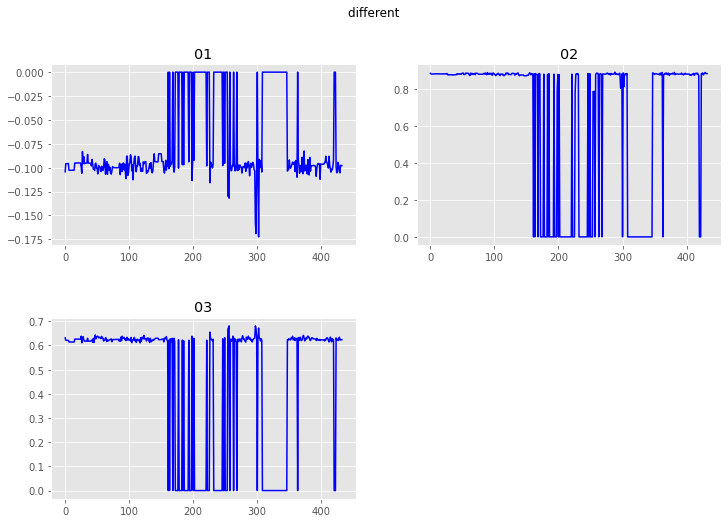

In [15]:
x = data_from0['x']
y = data_from0['y']
z = data_from0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

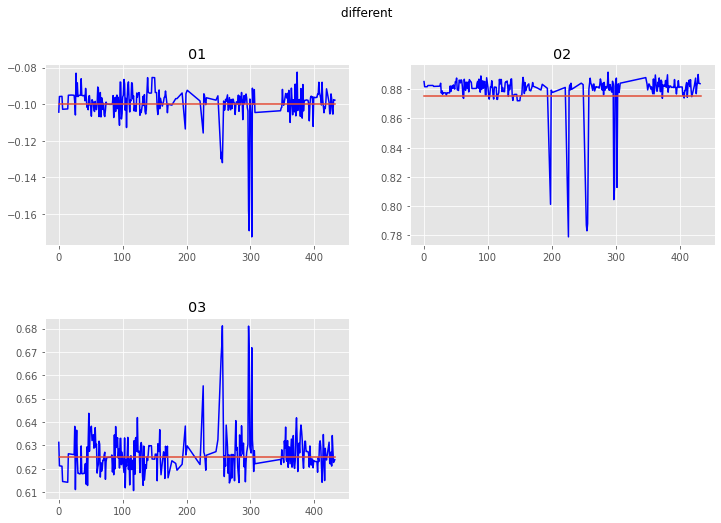

In [16]:
x0 = df0['x']
y0 = df0['y']
z0 = df0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker23获得，在link6上

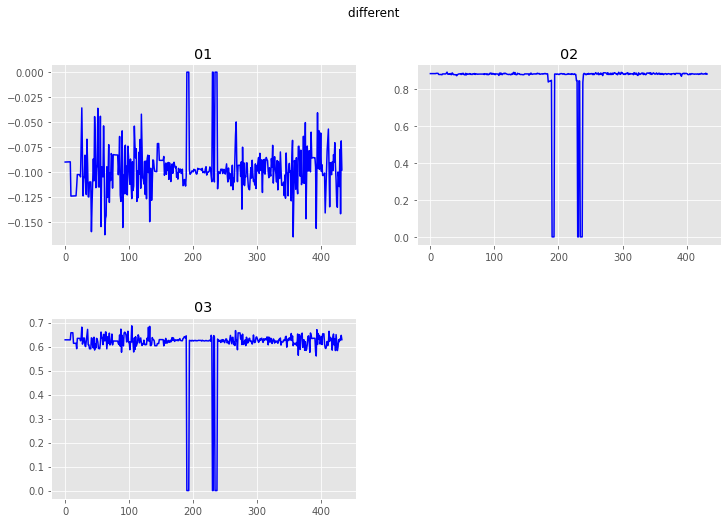

In [17]:
x = data_from23['x']
y = data_from23['y']
z = data_from23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

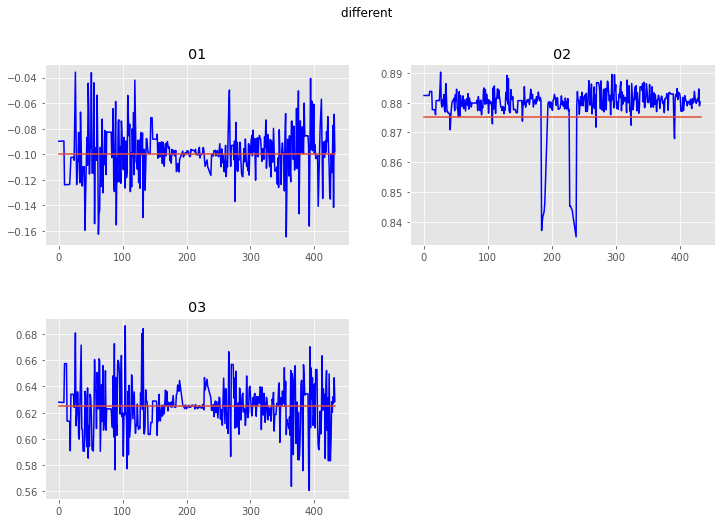

In [18]:
x23 = df23['x']
y23 = df23['y']
z23 = df23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z23, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker10获得，位于link8上

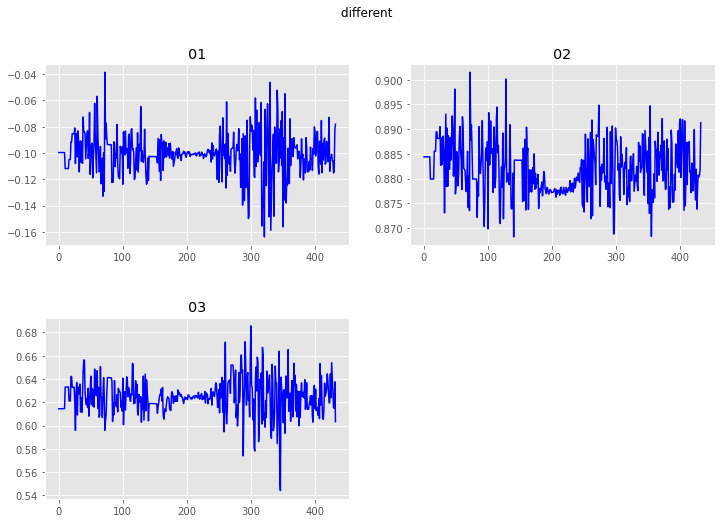

In [19]:
x = data_from10['x']
y = data_from10['y']
z = data_from10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')


### 去零

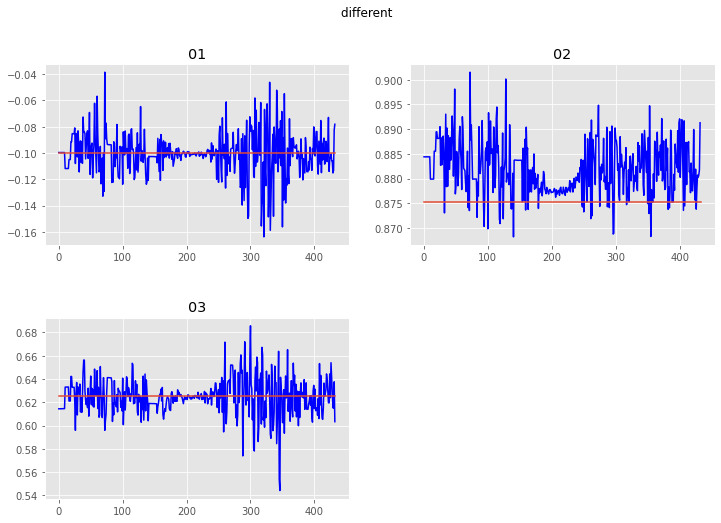

In [20]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 去零后汇总

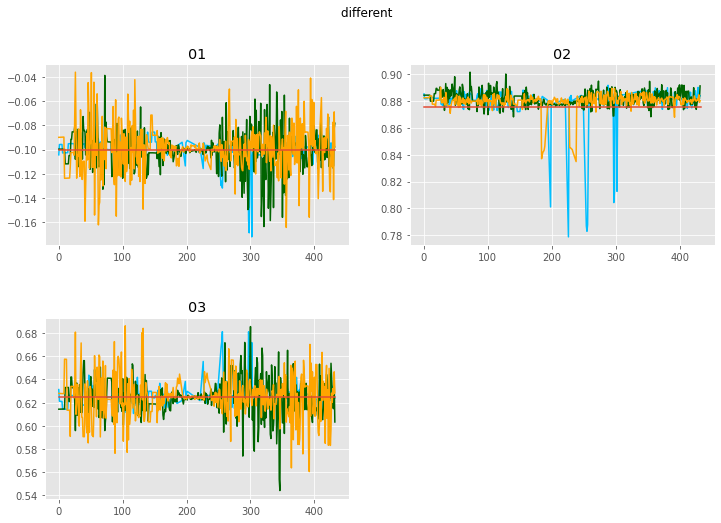

In [21]:
fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='deepskyblue')
ax221.plot(x10, color='darkgreen')
ax221.plot(x23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='deepskyblue')
ax222.plot(y10, color='darkgreen')
ax222.plot(y23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='deepskyblue')
ax223.plot(z10, color='darkgreen')
ax223.plot(z23, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 卡尔曼滤波器

当没有传感器输入时怎么办？

If at a time t the measurement is missing, only the time-update is computed and the measurement update must be skipped. 


https://math.stackexchange.com/questions/982982/kalman-filter-with-missing-measurement-inputs

如何理解并选择Covariance？processNoiseCov

### use kf on marker10

In [22]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
# 6: a, b, c, da, db, dc; 3: observe conditions
kalman_ori = cv2.KalmanFilter(6, 3) 

# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
kalman_ori.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
# zhuangtaizhuanyi matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)
kalman_ori.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)

# Process Noise noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5
kalman_ori.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

# Measurement Noise Covariance
kalman_pos.measurementNoiseCov = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 1]], np.float32)*0.4


# initalize measurement and predictions

In [23]:
# initalize measurement and predictions
last_measurement_pos10 = current_measurement_pos10 = (data_from10['x'][0],data_from10['y'][0],data_from10['z'][0])
last_prediction_pos10 = current_prediction_pos10 = (data_from10['x'][0],data_from10['y'][0],data_from10['z'][0])

last_measurement_ori10 = current_measurement_ori10 = (data_from10['alpha'][0],data_from10['beta'][0],data_from10['gamma'][0])
last_prediction_ori10 = current_prediction_ori10 = (data_from10['alpha'][0],data_from10['beta'][0],data_from10['gamma'][0])

## kalman filter section

In [24]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos10, last_measurement_pos10, current_prediction_pos10, last_prediction_pos10
    global current_measurement_ori10, last_measurement_ori10, current_prediction_ori10, last_prediction_ori10
    # save current prediction as last prediction
    last_prediction_pos10 = current_prediction_pos10
    last_prediction_ori10 = current_prediction_ori10 
    # save current measurement as last measurement
    last_measurement_pos10 = current_measurement_pos10
    last_measurement_ori10 = current_measurement_ori10
    x = position[0]
    y = position[1]
    z = position[2]
    euler = (orientation[0],orientation[1],orientation[2])
  #  print("orientation: ", euler)
    # rxyz: rotational axis; sxyz: static axis
   # angle = tf.transformations.euler_from_quaternion(quat,'sxyz')
   # quat2 = tf.transformations.quaternion_from_euler(quat,'sxyz')
   # print("angles: ", a, b, c)
 #   print(x)
    
    # current_measurement
    current_measurement_pos10 = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]]) 
  #  current_measurement_ori = np.array([[np.float32(a)], [np.float32(b)], [np.float32(c)]]) 
 #   print(current_measurement)

    # correction phase
    kalman_pos.correct(current_measurement_pos10) 
 #   kalman_ori.correct(current_measurement_ori) 
    # current kalman prediction
    if(x!=0):
        current_prediction_pos10 = kalman_pos.predict() 
 #   current_prediction_ori = kalman_ori.predict() 
    
 #   print(x)
  #  print(current_prediction_pos)
 #   print("prediction: ", current_prediction)
    return current_prediction_pos10, orientation

In [25]:
filtered_pos_array10 = np.zeros((len(data_from10['x']),3))

In [29]:
for i in range (0,len(data_from10['x'])):
    pos=(data_from10['x'][i],data_from10['y'][i],data_from10['z'][i])
    ori=(data_from10['alpha'][i],data_from10['beta'][i],data_from10['gamma'][i])
    filtered_pos, filtered_ori = kalman_filter(pos,ori)
    filtered_pos_array10[i][0] = filtered_pos[0]
    filtered_pos_array10[i][1] = filtered_pos[1]
    filtered_pos_array10[i][2] = filtered_pos[2]
    

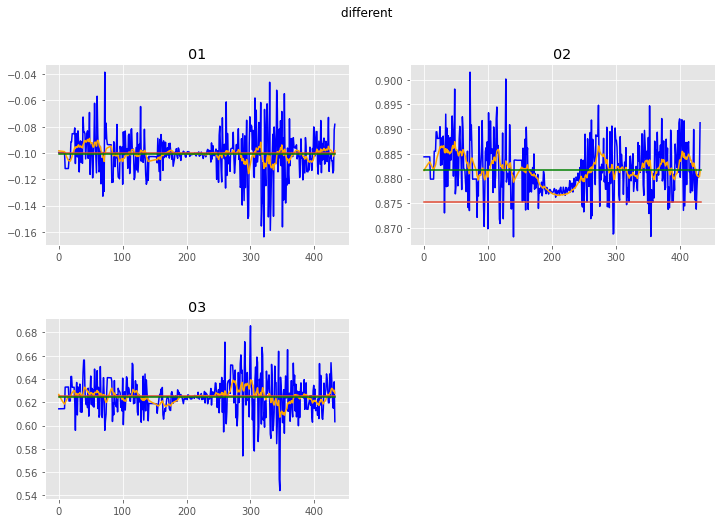

In [30]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']
xf10 = filtered_pos_array10[:,0]
yf10 = filtered_pos_array10[:,1]
zf10 = filtered_pos_array10[:,2]

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
ax221.plot(xf10, color='orange')
mx = df10[['x']].mean(axis=0)
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
x_average = [mx,mx]
ax221.plot(x_coordinates, y_coordinates)
ax221.plot(x_coordinates, x_average,color='green')

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
ax222.plot(yf10, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

my = df10[['y']].mean(axis=0)
y_average = [my,my]
ax222.plot(x_coordinates, y_average,color='green')

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zf10, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

mz = df10[['z']].mean(axis=0)
z_average = [mz,mz]
ax223.plot(x_coordinates, z_average,color='green')


intuition:在深度上有bias (y方向)

![direction](https://github.com/nilshao/data_process/raw/master/01static_camera_calibration/base_direction_xyz.png)

In [28]:
print(("%f milimeters in x direction") % ((mx-xt)*1000))
print(("%f milimeters in y direction") % ((my-yt)*1000))
print(("%f milimeters in z direction") % ((mz-zt)*1000))

-0.669793 milimeters in x direction
6.517710 milimeters in y direction
-0.172565 milimeters in z direction


## use on marker 23

In [31]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
# 6: a, b, c, da, db, dc; 3: observe conditions
kalman_ori = cv2.KalmanFilter(6, 3) 

# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
kalman_ori.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
# zhuangtaizhuanyi matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)
kalman_ori.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)

# noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5
kalman_ori.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

# Measurement Noise Covariance
kalman_pos.measurementNoiseCov = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 1]], np.float32)*0.4

In [32]:
# initalize measurement and predictions
last_measurement_pos23 = current_measurement_pos23 = (data_from23['x'][0],data_from23['y'][0],data_from23['z'][0])
last_prediction_pos23 = current_prediction_pos23 = (data_from23['x'][0],data_from23['y'][0],data_from23['z'][0])

last_measurement_ori23 = current_measurement_ori23 = (data_from23['alpha'][0],data_from23['beta'][0],data_from23['gamma'][0])
last_prediction_ori23 = current_prediction_ori23 = (data_from23['alpha'][0],data_from23['beta'][0],data_from23['gamma'][0])

In [33]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos23, last_measurement_pos23, current_prediction_pos23, last_prediction_pos23
    global current_measurement_ori23, last_measurement_ori23, current_prediction_ori23, last_prediction_ori23
    # save current prediction as last prediction
    last_prediction_pos23 = current_prediction_pos23
    last_prediction_ori23 = current_prediction_ori23 
    # save current measurement as last measurement
    last_measurement_pos23 = current_measurement_pos23
    last_measurement_ori23 = current_measurement_ori23
    x = position[0]
    y = position[1]
    z = position[2]
    euler = (orientation[0],orientation[1],orientation[2])
  #  print("orientation: ", euler)
    # rxyz: rotational axis; sxyz: static axis
   # angle = tf.transformations.euler_from_quaternion(quat,'sxyz')
   # quat2 = tf.transformations.quaternion_from_euler(quat,'sxyz')
   # print("angles: ", a, b, c)
 #   print(x)
    
    # current_measurement
    current_measurement_pos23 = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]]) 
  #  current_measurement_ori = np.array([[np.float32(a)], [np.float32(b)], [np.float32(c)]]) 
 #   print(current_measurement)

    # correction phase
    kalman_pos.correct(current_measurement_pos23) 
 #   kalman_ori.correct(current_measurement_ori) 

    # current kalman prediction
    if(x!=0):
        current_prediction_pos23 = kalman_pos.predict() 
 #   current_prediction_ori = kalman_ori.predict() 
    
 #   print(x)
 #   print(current_prediction_pos)
 #   print("prediction: ", current_prediction)
    return current_prediction_pos23, orientation

In [34]:
filtered_pos_array23 = np.zeros((len(data_from23['x']),3))

In [38]:
for i in range (0,len(data_from23['x'])):
    pos=(data_from23['x'][i],data_from23['y'][i],data_from23['z'][i])
    ori=(data_from23['alpha'][i],data_from23['beta'][i],data_from23['gamma'][i])
    filtered_pos, filtered_ori = kalman_filter(pos,ori)
    filtered_pos_array23[i][0] = filtered_pos[0]
    filtered_pos_array23[i][1] = filtered_pos[1]
    filtered_pos_array23[i][2] = filtered_pos[2]
    

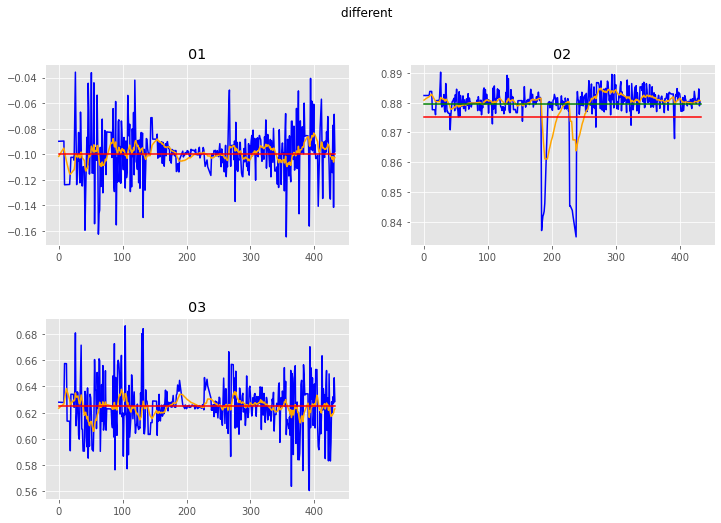

In [39]:
x23 = df23['x']
y23 = df23['y']
z23 = df23['z']
xf23 = filtered_pos_array23[:,0]
yf23 = filtered_pos_array23[:,1]
zf23 = filtered_pos_array23[:,2]

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x23, color='blue')
ax221.plot(xf23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates,color='red')


ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y23, color='blue')
ax222.plot(yf23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates,color='red')
my = df23[['y']].mean(axis=0)
y_average = [my,my]
ax222.plot(x_coordinates, y_average,color='green')

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z23, color='blue')
ax223.plot(zf23, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates,color='red')


In [40]:
print(("%f milimeters in x direction") % ((mx-xt)*1000))
print(("%f milimeters in y direction") % ((my-yt)*1000))
print(("%f milimeters in z direction") % ((mz-zt)*1000))

-0.669793 milimeters in x direction
4.416450 milimeters in y direction
-0.172565 milimeters in z direction


## use on marker 0



In [41]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
# 6: a, b, c, da, db, dc; 3: observe conditions
kalman_ori = cv2.KalmanFilter(6, 3) 

# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
kalman_ori.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
# zhuangtaizhuanyi matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)
kalman_ori.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)

# noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5
kalman_ori.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

# Measurement Noise Covariance
kalman_pos.measurementNoiseCov = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 1]], np.float32)*1e-1

In [42]:
# initalize measurement and predictions
last_measurement_pos0 = current_measurement_pos0 = (data_from0['x'][0],data_from0['y'][0],data_from0['z'][0])
last_prediction_pos0 = current_prediction_pos0 = (data_from0['x'][0],data_from0['y'][0],data_from0['z'][0])

last_measurement_ori0 = current_measurement_ori0 = (data_from0['alpha'][0],data_from0['beta'][0],data_from0['gamma'][0])
last_prediction_ori0 = current_prediction_ori0 = (data_from0['alpha'][0],data_from0['beta'][0],data_from0['gamma'][0])

In [43]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos0, last_measurement_pos0, current_prediction_pos0, last_prediction_pos0
    global current_measurement_ori0, last_measurement_ori0, current_prediction_ori0, last_prediction_ori0
    # save current prediction as last prediction
    last_prediction_pos0 = current_prediction_pos0
    last_prediction_ori0 = current_prediction_ori0
    # save current measurement as last measurement
    last_measurement_pos0 = current_measurement_pos0
    last_measurement_ori0 = current_measurement_ori0
    x = position[0]
    y = position[1]
    z = position[2]
    euler = (orientation[0],orientation[1],orientation[2])
  #  print("orientation: ", euler)
    # rxyz: rotational axis; sxyz: static axis
   # angle = tf.transformations.euler_from_quaternion(quat,'sxyz')
   # quat2 = tf.transformations.quaternion_from_euler(quat,'sxyz')
   # print("angles: ", a, b, c)
 #   print(x)
    
    # current_measurement
    current_measurement_pos0 = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]]) 
  #  current_measurement_ori = np.array([[np.float32(a)], [np.float32(b)], [np.float32(c)]]) 
 #   print(current_measurement)

    # correction phase
    kalman_pos.correct(current_measurement_pos0) 
 #   kalman_ori.correct(current_measurement_ori) 
    
    
    # current kalman prediction
    if(x!=0):
        current_prediction_pos0 = kalman_pos.predict() 
 #   current_prediction_ori = kalman_ori.predict() 
    
 #   print(x)
 #   print(current_prediction_pos)
 #   print("prediction: ", current_prediction)
    return current_prediction_pos0, orientation

In [44]:
filtered_pos_array0 = np.zeros((len(data_from0['x']),3))

In [48]:
for i in range (0,len(data_from0['x'])):
    
    pos=(data_from0['x'][i],data_from0['y'][i],data_from0['z'][i])
    ori=(data_from0['alpha'][i],data_from0['beta'][i],data_from0['gamma'][i])
    filtered_pos, filtered_ori = kalman_filter(pos,ori)
    filtered_pos_array0[i][0] = filtered_pos[0]
    filtered_pos_array0[i][1] = filtered_pos[1]
    filtered_pos_array0[i][2] = filtered_pos[2]
    

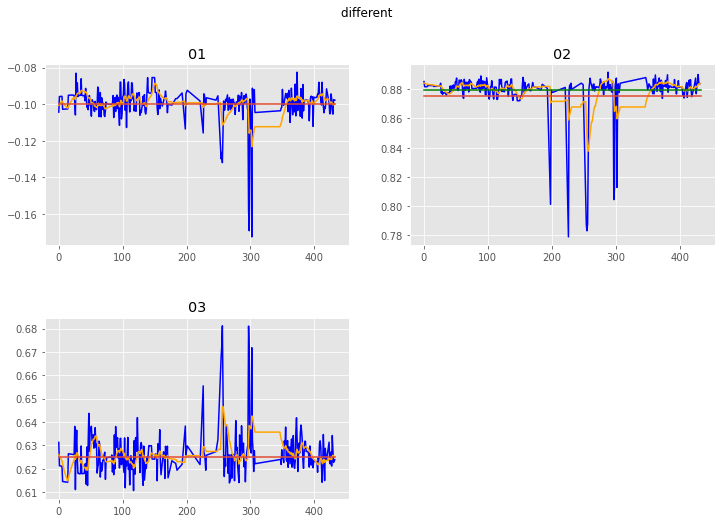

In [49]:
x0 = df0['x']
y0 = df0['y']
z0 = df0['z']
xf0 = filtered_pos_array0[:,0]
yf0 = filtered_pos_array0[:,1]
zf0 = filtered_pos_array0[:,2]

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='blue')
ax221.plot(xf0, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='blue')
ax222.plot(yf0, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)
my = df0[['y']].mean(axis=0)
y_average = [my,my]
ax222.plot(x_coordinates, y_average,color='green')

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='blue')
ax223.plot(zf0, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

In [50]:
print(("%f milimeters in x direction") % ((mx-xt)*1000))
print(("%f milimeters in y direction") % ((my-yt)*1000))
print(("%f milimeters in z direction") % ((mz-zt)*1000))

-0.669793 milimeters in x direction
3.938804 milimeters in y direction
-0.172565 milimeters in z direction


## ---

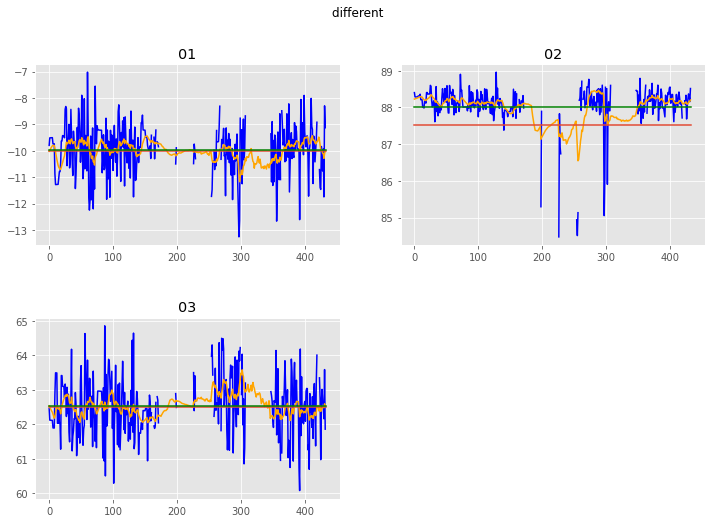

In [52]:
x = 100*(df0['x']+df10['x']+df23['x'])/3
y = 100*(df0['y']+df10['y']+df23['y'])/3
z = 100*(df0['z']+df10['z']+df23['z'])/3
xf = 100*(filtered_pos_array0[:,0]+filtered_pos_array10[:,0]+filtered_pos_array23[:,0])/3
yf = 100*(filtered_pos_array0[:,1]+filtered_pos_array10[:,1]+filtered_pos_array23[:,1])/3
zf = 100*(filtered_pos_array0[:,2]+filtered_pos_array10[:,2]+filtered_pos_array23[:,2])/3

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax221.plot(xf, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [100*xt, 100*xt]
ax221.plot(x_coordinates, y_coordinates)
mx = 100*(df0[['x']].mean(axis=0)+df10[['x']].mean(axis=0)+df23[['x']].mean(axis=0))/3
y_average = [mx,mx]
ax221.plot(x_coordinates, y_average,color='green')

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax222.plot(yf, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [100*yt, 100*yt]
ax222.plot(x_coordinates, y_coordinates)
my = 100*(df0[['y']].mean(axis=0)+df10[['y']].mean(axis=0)+df23[['y']].mean(axis=0))/3
y_average = [my,my]
ax222.plot(x_coordinates, y_average,color='green')

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')
ax223.plot(zf, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [100*zt, 100*zt]
ax223.plot(x_coordinates, y_coordinates)
mz = 100*(df0[['z']].mean(axis=0)+df10[['z']].mean(axis=0)+df23[['z']].mean(axis=0))/3
y_average = [mz,mz]
ax223.plot(x_coordinates, y_average,color='green')

## 如何多传感器融合？

KF:

http://campar.in.tum.de/Chair/KalmanFilter

https://elib.dlr.de/62656/1/TobergteIROS-Sensorfusion.pdf

https://www.researchgate.net/publication/221908847_Kalman_Filtering_for_Sensor_Fusion_in_a_Human_Tracking_System?enrichId=rgreq-e50af59bcd52006262b578ee14a91b2e-XXX&enrichSource=Y292ZXJQYWdlOzIyMTkwODg0NztBUzoxMDMwNTMwMDQ5MDI0MDZAMTQwMTU4MTE1OTc5NA%3D%3D&el=1_x_3&_esc=publicationCoverPdf

http://www.paper.edu.cn/scholar/showpdf/MUT2UN2IOTD0MxeQh

https://www.sciencedirect.com/science/article/abs/pii/S0005109804000287

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1254663

https://www.researchgate.net/publication/224680746_Kalman_filter_algorithms_for_a_multi-sensor_system


online tutorial:

https://simondlevy.academic.wlu.edu/kalman-tutorial/the-extended-kalman-filter-an-interactive-tutorial-for-non-experts-part-13/


LSTM:

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9091174

问题